In [4]:
import os
%cd C:\Users\benjo\Documents\Projects\wildlife-camtrap-classification

C:\Users\benjo\Documents\Projects\wildlife-camtrap-classification


0. Set-Up

In [5]:
from src.models.model import create_model
import torch
import json
import pandas as pd
from torch.utils.data import DataLoader
from src.data.dataset import CCTImageDataset, transform_images,create_dataloader

model_params = 'best_model.pth'
model = create_model('data/cct/labels.json')   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Slightly redundant but done for practice if I use gpu machine.
model.load_state_dict(torch.load(model_params))
model.to(device)

#Setting up the dataloader again in this notebook
img_dir = 'data/cct/images/'
test_df = pd.read_csv('data/cct/splits/test.csv')
with open('data/cct/labels.json','r') as f:
    label_map = json.load(f)
    
test_t = transform_images(train = False,size = 224)
test_dataset = CCTImageDataset(test_df,img_dir,label_map,test_t)
test_loader = create_dataloader(
    test_dataset,
    batch_size=32,
    shuffle= False
)



c:\Users\benjo\Documents\Projects\wildlife-camtrap-classification\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
'(ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)), '(Request ID: a5ab73a9-1d04-43a1-a8c8-0f81ec174f69)')' thrown while requesting HEAD https://huggingface.co/timm/efficientnet_b0.ra_in1k/resolve/main/model.safetensors
Retrying in 1s [Retry 1/5].


1. Metrics calculation

In [6]:
from src.helpers.test import compute_preds
y_true,y_preds = compute_preds(test_loader,model,device)


Saving the test true and predictons to save retraining everytime

In [7]:
pd.DataFrame(
    {'y_true' : y_true,
    'y_preds': y_preds}
).to_csv('data/cct/test/test_data.csv',index= False)


Classification Report and Plotting of Heatmap to represent confusion matrix

c:\Users\benjo\Documents\Projects\wildlife-camtrap-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\benjo\Documents\Projects\wildlife-camtrap-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\benjo\Documents\Projects\wildlife-camtrap-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this b

{'0': {'precision': 0.9713827226531158, 'recall': 0.7950963222416813, 'f1-score': 0.8744432406404238, 'support': 4568.0}, '1': {'precision': 0.2518518518518518, 'recall': 0.723404255319149, 'f1-score': 0.37362637362637363, 'support': 47.0}, '2': {'precision': 0.597254004576659, 'recall': 0.8105590062111802, 'f1-score': 0.6877470355731226, 'support': 644.0}, '3': {'precision': 0.6089385474860335, 'recall': 0.3732876712328767, 'f1-score': 0.46284501061571126, 'support': 584.0}, '4': {'precision': 0.4720670391061452, 'recall': 0.8407960199004975, 'f1-score': 0.6046511627906976, 'support': 201.0}, '5': {'precision': 0.6666666666666666, 'recall': 0.41935483870967744, 'f1-score': 0.5148514851485149, 'support': 124.0}, '6': {'precision': 0.25045871559633026, 'recall': 0.6610169491525424, 'f1-score': 0.36327345309381237, 'support': 413.0}, '7': {'precision': 0.5206611570247934, 'recall': 0.4846153846153846, 'f1-score': 0.50199203187251, 'support': 130.0}, '8': {'precision': 0.0, 'recall': 0.0,

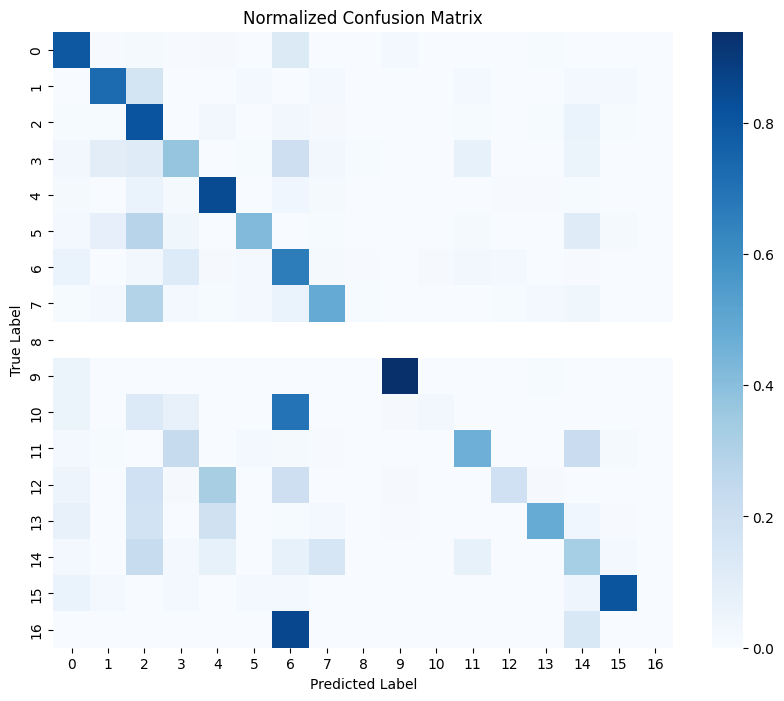

In [24]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt


print(classification_report(y_true,y_preds,output_dict=True))
report_dict = classification_report(y_true,y_preds,output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv('reports/classification_report.csv',index_label= False)


confusion = confusion_matrix(y_true,y_preds)
confusion_norm = confusion.astype('float') / confusion.sum(axis = 1,keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_norm,cmap = 'Blues',annot=False)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('reports/figures/Confusion_matrix.png',dpi = 300)
plt.show()

Training Report and Plots
For Epoch wise loss and accuracy

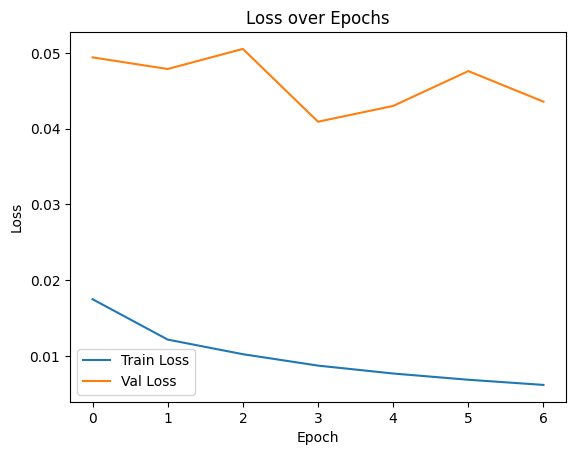

In [17]:
per_log = pd.read_csv('reports/performance_log.csv')
plt.plot(per_log['epoch'], per_log['train_loss'], label='Train Loss')
plt.plot(per_log['epoch'], per_log['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.savefig('reports/figures/Train_Val_Loss.png',dpi = 300)
plt.show()

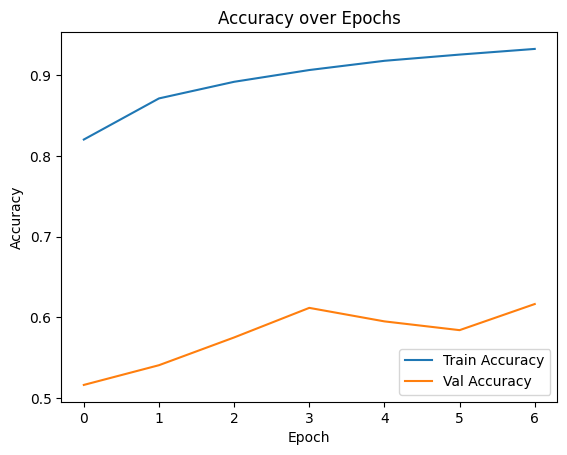

In [18]:
plt.plot(per_log['epoch'], per_log['train_acc'], label='Train Accuracy')
plt.plot(per_log['epoch'], per_log['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.savefig('reports/figures/Train_Val_Acc.png',dpi = 300)
plt.show()

Per class F1 Scores 